In [3]:
import openai
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import pickle
from tqdm import tqdm, trange
from IPython.display import display, Markdown, HTML
import re
from matplotlib.animation import FuncAnimation

from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval, AnswerRelevancyMetric, FaithfulnessMetric, HallucinationMetric
from deepeval.evaluate import evaluate, DisplayConfig

In [4]:
# --- Funkcje ---
def get_response(prompt, temperature=0.7):
    response = openai.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        max_tokens=300
    )
    return response.choices[0].message.content.strip()

def normalize_markdown(text):
    # usuń nagłówki i znaczniki
    text = re.sub(r"`{1,3}[^`]+`{1,3}", "", text)  # kod inline
    text = re.sub(r"#+\\s*", "", text)            # nagłówki
    text = re.sub(r"\\*\\*?|__?", "", text)        # pogrubienie/kursywa
    text = re.sub(r"!?\[.*?\]\(.*?\)", "", text)   # linki i obrazki
    text = re.sub(r"[\\*\\-\\_]{2,}", " ", text)   # linie poziome
    return text.strip()

def get_similarity(text1, text2):
    text1 = normalize_markdown(text1)
    text2 = normalize_markdown(text2)
    emb1 = embedding_model.encode([text1])[0]
    emb2 = embedding_model.encode([text2])[0]
    return cosine_similarity([emb1], [emb2])[0][0]

In [5]:
# --- Modele embeddingowe ---
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [6]:
# --- Parametry ---
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
openai.api_key = OPENAI_API_KEY
N_SIMULATIONS = 100
MODEL = 'gpt-4.1-nano'
TEMPERATURE = 0.7
PROMPT = "Wyjaśnij, czym jest fotosynteza, w sposób zrozumiały dla ucznia szkoły podstawowej."
REFERENCE = "Fotosynteza to proces, w którym rośliny zamieniają światło słoneczne, wodę i dwutlenek węgla w tlen i cukier."

CONTEXT = [(
    "Fotosynteza to proces, w którym zielone rośliny, algi i niektóre bakterie przekształcają energię świetlną "
    "w energię chemiczną. Zachodzi ona głównie w chloroplastach, zawierających chlorofil. "
    "W trakcie fotosyntezy rośliny pochłaniają dwutlenek węgla (CO2) z powietrza i wodę (H2O) z gleby. "
    "Pod wpływem światła słonecznego przekształcają te substancje w glukozę (cukier) i tlen (O2). "
    "Równanie ogólne fotosyntezy to: 6CO2 + 6H2O + światło → C6H12O6 + 6O2. "
    "Fotosynteza jest kluczowa dla życia na Ziemi, ponieważ produkuje tlen i stanowi podstawę łańcucha pokarmowego."
)]
RETRIEVAL_CONTEXT=[(
            "Chlorofil to zielony barwnik znajdujący się w chloroplastach, który umożliwia absorpcję światła potrzebnego do fotosyntezy."
            "Dwutlenek węgla jest pobierany z atmosfery przez aparaty szparkowe na liściach roślin."
            "Woda dostarczana jest do liści przez system korzeniowy i naczynia przewodzące."
)]

In [6]:
# --- Metryki LLM ---
answer_relevancy_metric = AnswerRelevancyMetric(threshold=TEMPERATURE, model=MODEL,include_reason=False)
faithfulness_metric = FaithfulnessMetric(threshold=TEMPERATURE, model=MODEL, include_reason=False)
hallucination_metric = HallucinationMetric(threshold=TEMPERATURE, model=MODEL, include_reason=False)
correctness_metric = GEval(
    name="Correctness",
    model=MODEL,
    evaluation_steps=[
        "Check whether the facts in 'actual output' contradicts any facts in 'expected output'",
        "You should also heavily penalize omission of detail",
        "Vague language, or contradicting OPINIONS, are OK"
    ],
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT]
)

In [7]:
# --- Symulacja Monte Carlo (MC) ---
outputs = []
for i in tqdm(range(N_SIMULATIONS)):
    output = get_response(PROMPT, TEMPERATURE)
    outputs.append(output)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:18<00:00,  3.19s/it]


In [12]:
test_cases = []
for i in range(len(outputs)):
    similarity = get_similarity(outputs[i], REFERENCE)
    length = len(outputs[i].split())

    test_case = LLMTestCase(
        input=PROMPT,
        actual_output=outputs[i],
        expected_output=REFERENCE,
        retrieval_context=RETRIEVAL_CONTEXT,
        context=CONTEXT
    )

    test_case.metadata = {
        "simulation": i + 1,
        "output": outputs[i],
        "similarity": similarity,
        "length": length
    }
    
    test_cases.append(test_case)

In [13]:
results = []
for i in range(20):
    from_i = i*5
    to_i = (i+1)*5
    print(from_i, to_i)
    ts=test_cases[from_i:to_i]
    eval_result = evaluate(
        test_cases=ts,
        metrics=[answer_relevancy_metric, faithfulness_metric, hallucination_metric, correctness_metric],
        display_config=DisplayConfig(show_indicator=False,print_results=False,verbose_mode=False, display_option="failling")
    )
    for i in range(len(ts)):
        answer_relevancy = None
        faithfulness = None
        hallucination = None
        correctness = None
        if eval_result is not None and i < len(eval_result.test_results):
            for m in eval_result.test_results[i].metrics_data:
                if m.name == 'Answer Relevancy':
                    answer_relevancy = m.score
                elif m.name == 'Faithfulness':
                    faithfulness = m.score
                elif m.name == 'Hallucination':
                    hallucination = m.score
                elif m.name == 'Correctness [GEval]':
                    correctness = m.score
                else:
                    print(m.name)
                    raise ValueError
    
        results.append({
            "simulation": ts[i].metadata["simulation"],
            "output": ts[i].metadata["output"],
            "similarity": ts[i].metadata["similarity"],
            "length": ts[i].metadata["length"],
            "answer_relevancy":answer_relevancy,
            "faithfulness":faithfulness,
            "hallucination":hallucination,
            'correctness': correctness
        })

0 5


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

5 10


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

10 15


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

15 20


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

20 25


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

25 30


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

30 35


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

35 40


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

40 45


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

45 50


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

50 55


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

55 60


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

60 65


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

65 70


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

70 75


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

75 80


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

80 85


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

85 90


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

90 95


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

95 100


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

In [14]:
df = pd.DataFrame(results)
df

,simulation,output,similarity,length,answer_relevancy,faithfulness,hallucination,correctness
0,1,"Fotosynteza to proces, w którym rośliny samodz...",0.743073,101,1.0,1.0,0.0,0.558607
1,2,"Fotosynteza to magiczny proces, który odbywa s...",0.713611,100,1.0,1.0,0.0,0.728698
2,3,"Fotosynteza to niezwykły proces, który zachodz...",0.598909,132,1.0,1.0,0.0,0.749826
3,4,"Fotosynteza to proces, który zachodzi w roślin...",0.757691,116,1.0,1.0,0.0,0.580029
4,5,"Fotosynteza to taki specjalny proces, który od...",0.724230,135,1.0,1.0,0.0,0.682705
...,...,...,...,...,...,...,...,...
95,96,"Fotosynteza to taki specjalny sposób, w jaki r...",0.765550,83,1.0,1.0,0.0,0.794037
96,97,"Fotosynteza to proces, który pozwala roślinom ...",0.783717,75,1.0,1.0,0.0,0.678236
97,98,Oczywiście! Fotosynteza to taki specjalny spos...,0.750189,92,1.0,1.0,0.0,0.753112
98,99,"Fotosynteza to proces, dzięki któremu rośliny ...",0.718592,73,1.0,1.0,0.0,0.664815


In [ ]:
df.to_csv('./data/df_classical.csv', header=True, index=False, sep=';', decimal=',')


📊 Statystyki:
       similarity      length
count  100.000000  100.000000
mean     0.741252  103.990000
std      0.036278   15.774609
min      0.598909   67.000000
25%      0.722821   92.000000
50%      0.745919  106.000000
75%      0.766012  114.250000
max      0.824070  135.000000


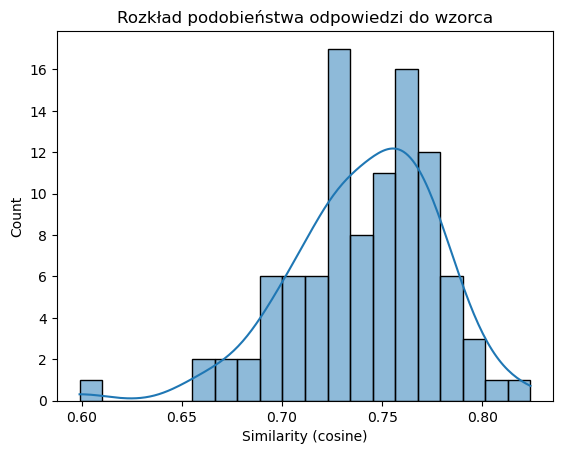

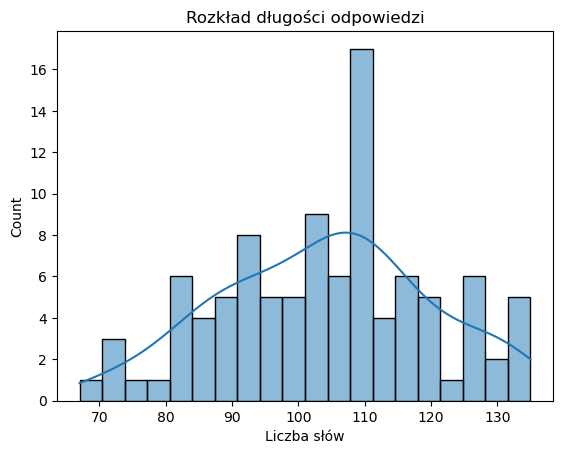

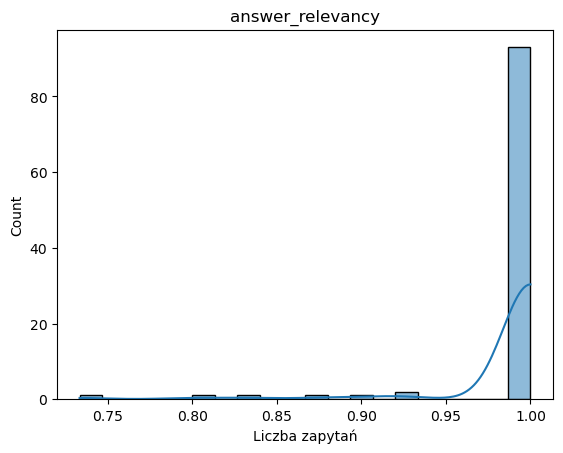

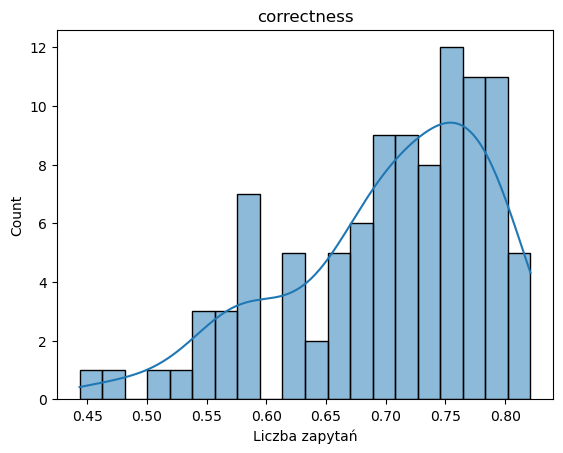

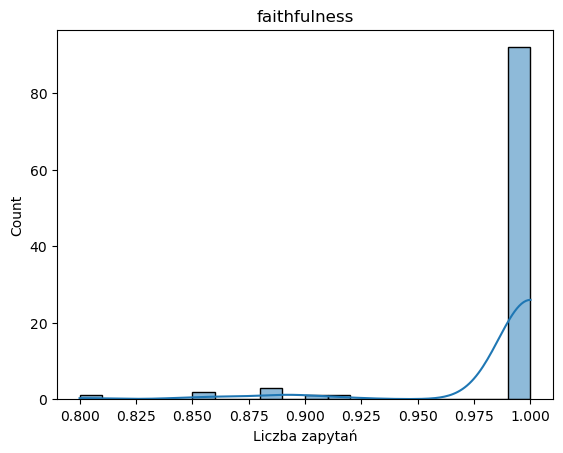

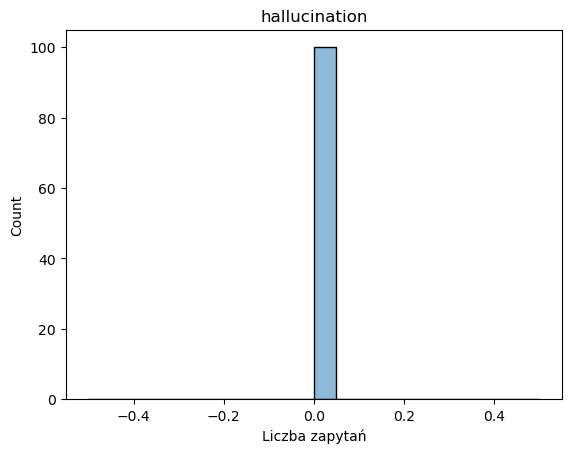

In [ ]:
# --- Analiza wyników ---
print("\n📊 Statystyki:")
print(df[["similarity", "length"]].describe())

# --- Wizualizacja ---
sns.histplot(df["similarity"], bins=20, kde=True)
plt.title("Rozkład podobieństwa odpowiedzi do wzorca")
plt.xlabel("Similarity (cosine)")
plt.show()

sns.histplot(df["length"], bins=20, kde=True)
plt.title("Rozkład długości odpowiedzi")
plt.xlabel("Liczba słów")
plt.show()

sns.histplot(df["answer_relevancy"], bins=20, kde=True)
plt.title("answer_relevancy")
plt.xlabel("Liczba zapytań")
plt.show()

sns.histplot(df["correctness"], bins=20, kde=True)
plt.title("correctness")
plt.xlabel("Liczba zapytań")
plt.show()

sns.histplot(df["faithfulness"], bins=20, kde=True)
plt.title("faithfulness")
plt.xlabel("Liczba zapytań")
plt.show()

sns.histplot(df["hallucination"], bins=20, kde=True)
plt.title("hallucination")
plt.xlabel("Liczba zapytań")
plt.show()

In [52]:
display(df[df['hallucination']==0])

,simulation,output,similarity,length,answer_relevancy,faithfulness,hallucination,contextual_precision,contextual_recall,contextual_relevancy
0,1,"Rośliny regulują fotosyntezę, korzystając z ef...",0.845567,61,1.000000,1.0,0.0,1.0,1.0,1.0
6,7,Rośliny regulują fotosyntezę dzięki efektom kw...,0.729024,69,0.750000,1.0,0.0,1.0,1.0,1.0
7,8,Rośliny regulują fotosyntezę dzięki efektom kw...,0.715793,69,1.000000,1.0,0.0,1.0,1.0,1.0
8,9,Rośliny regulują fotosyntezę korzystając z efe...,0.784269,55,0.714286,1.0,0.0,1.0,1.0,1.0
